In [1]:
# Imports
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm

In [2]:
train_mask_dir = "/home/ani/Documents/datasets/coco/masks/train/"
val_mask_dir = "/home/ani/Documents/datasets/coco/masks/val/"

train_images = glob(os.path.join(train_mask_dir, "*"))
val_images = glob(os.path.join(val_mask_dir, "*"))

In [3]:
# A quick Tensorflow Data loader
class DataLoader:
    """
    Assuming Dataset Path Structure:
    - Train Images: /media/ActiveTraining/Datasets/COCO/images/train
    - Val Images: /media/ActiveTraining/Datasets/COCO/images/val
    - Train Masks: /media/ActiveTraining/Datasets/COCO/masks/train
    - Val Masks: /media/ActiveTraining/Datasets/COCO/masks/val
    """
    def __init__(self, masks_dir, target_shape=(100, 100)):
        masks_dir = self.__fix_glob(masks_dir)
        self.files = tf.data.Dataset.list_files(masks_dir, shuffle=True)
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.target_shape = target_shape
        
    def __fix_glob(self, dir_path):
        if not dir_path.endswith("*"):
            dir_path = os.path.join(dir_path, "*")
            
        return dir_path
    
    @tf.function
    def parse_images(self, mask_path):
        mask = tf.io.read_file(mask_path)
        mask = tf.io.decode_jpeg(mask, channels=1)
        mask = tf.cast(mask, tf.float32)
        
        image_path = tf.strings.regex_replace(mask_path, "masks", "images")
        image = tf.io.read_file(image_path)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.cast(image, tf.float32)
        
        mask = tf.image.resize(
            mask, 
            self.target_shape, 
        ) / 255.
        
        image = tf.image.resize(
            image, 
            self.target_shape, 
        ) / 255.
        
        return image, mask
    
    @tf.function
    def data_generator(self, batch_size=64):
        dataset = self.files.map(self.parse_images)
        dataset = dataset.repeat()
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size = self.AUTOTUNE)
        return dataset

In [4]:
autoencoder = tf.keras.models.load_model("weights.h5")

In [5]:
batch_size = 32
epochs = 200
lr = 0.001
target_shape=(160, 160)
val_dataset = DataLoader(val_mask_dir, target_shape=target_shape)
val_generator = val_dataset.data_generator(batch_size)

In [6]:
inputs, targets = next(iter(val_generator))
preds = autoencoder.predict(inputs)

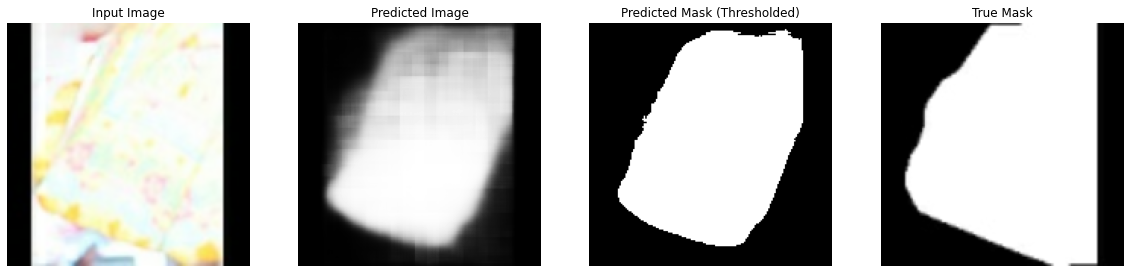

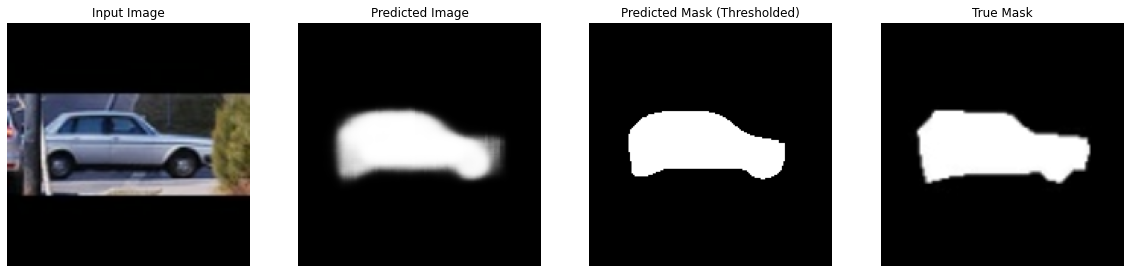

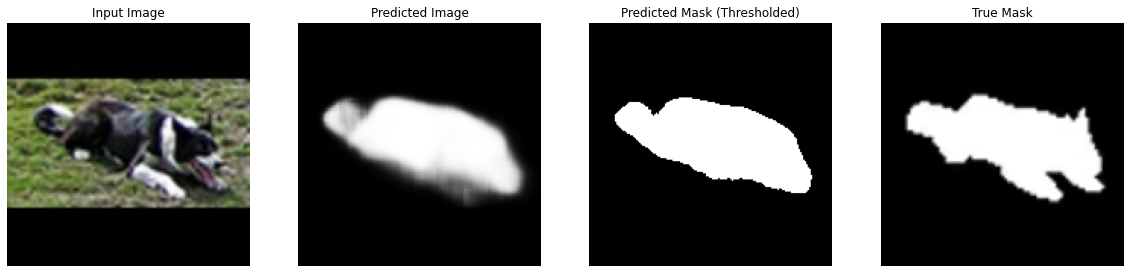

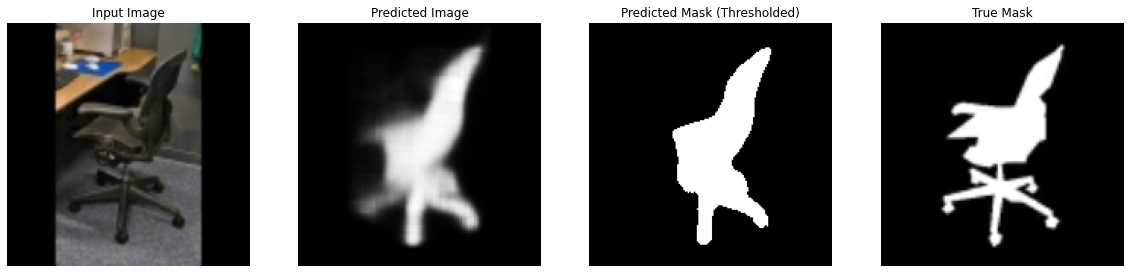

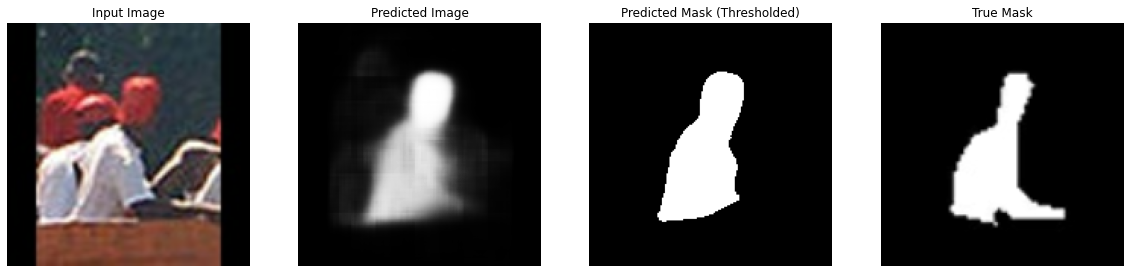

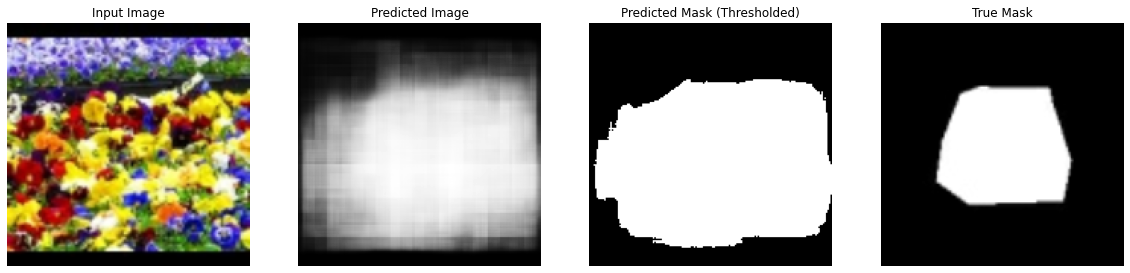

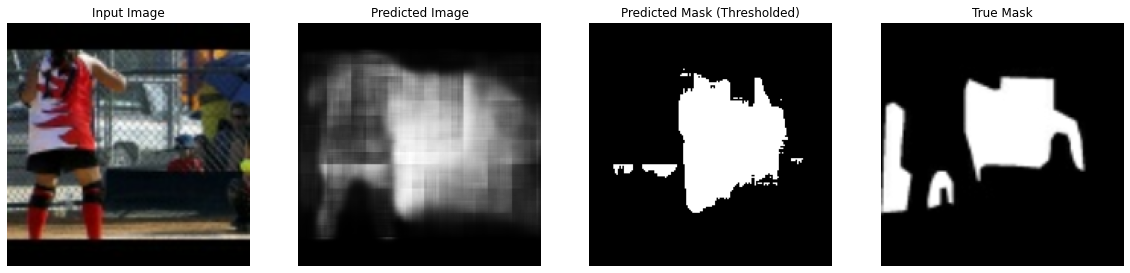

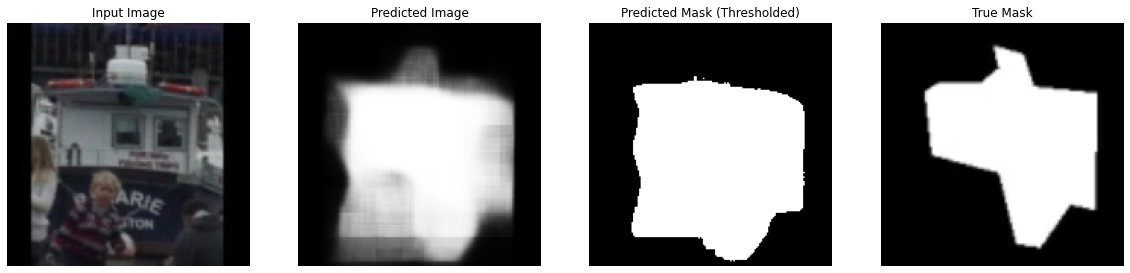

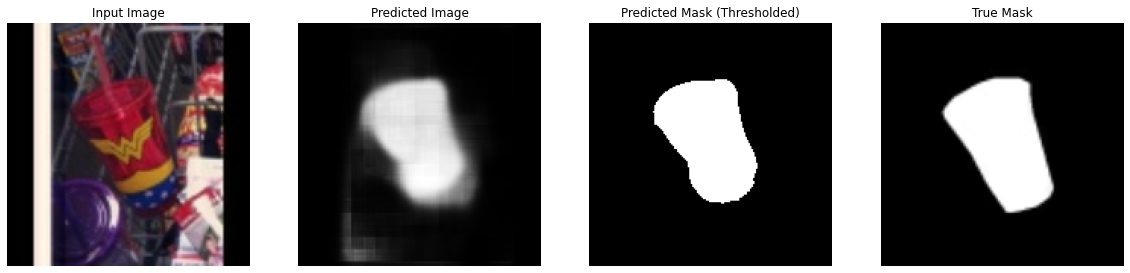

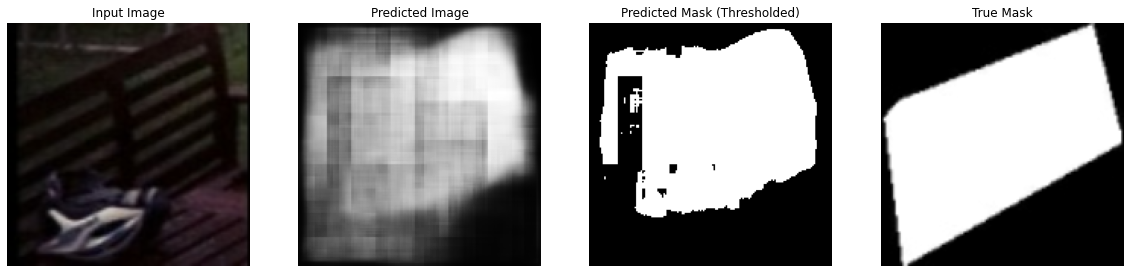

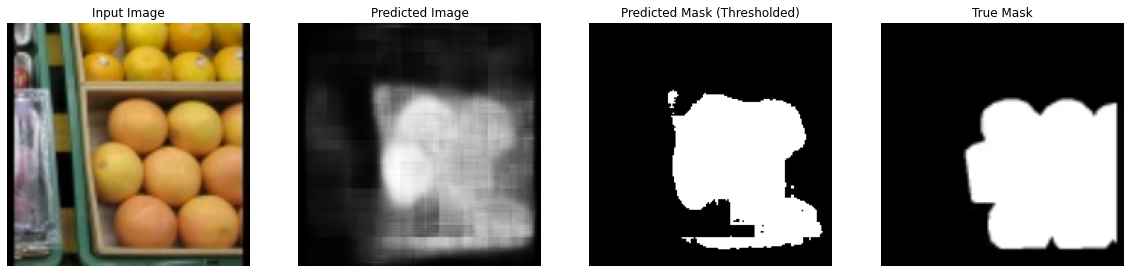

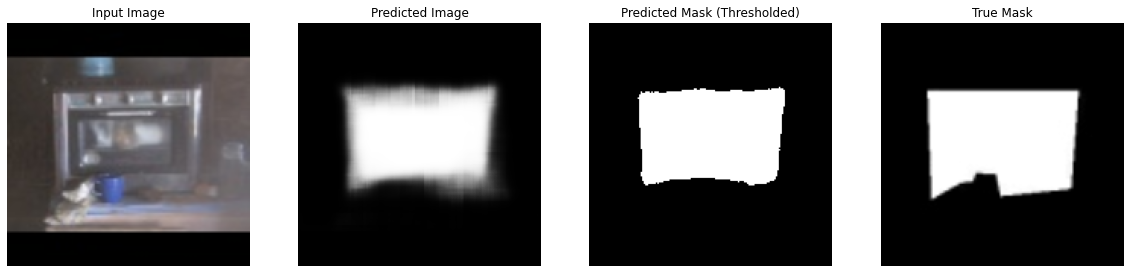

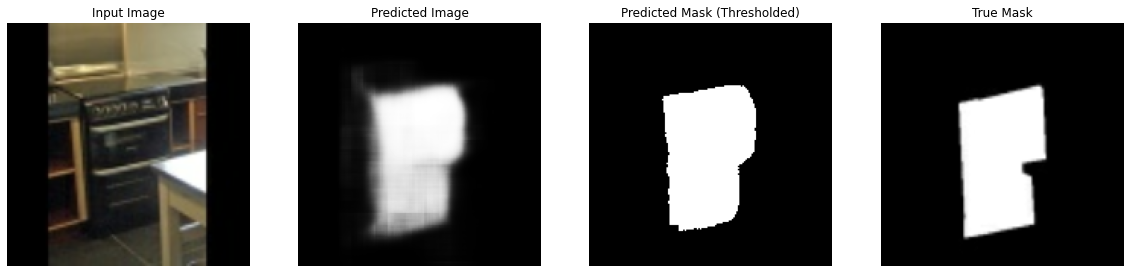

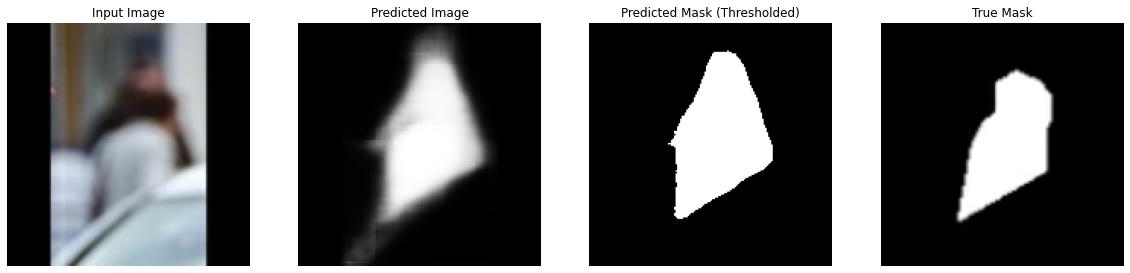

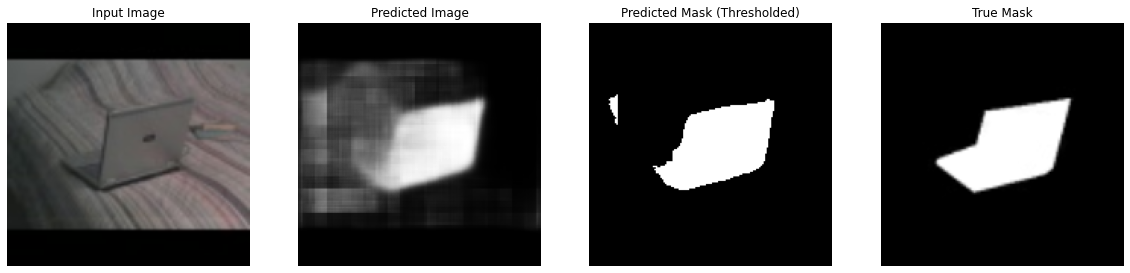

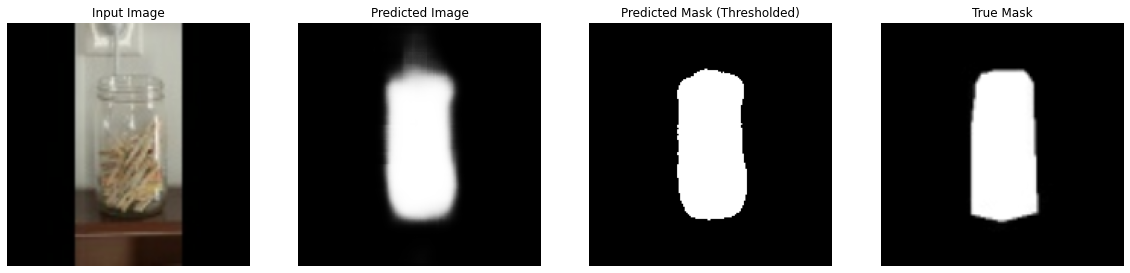

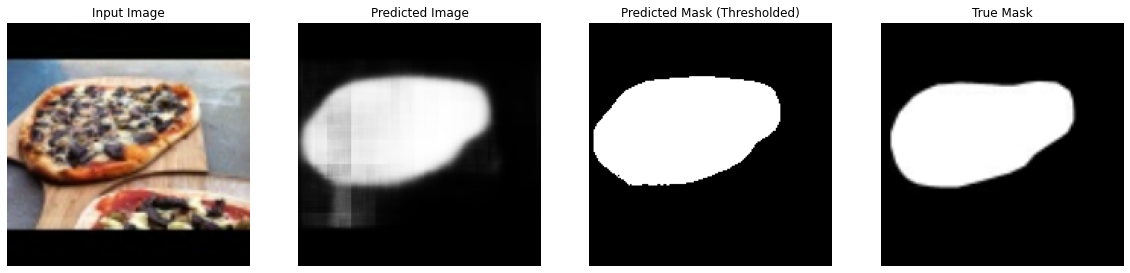

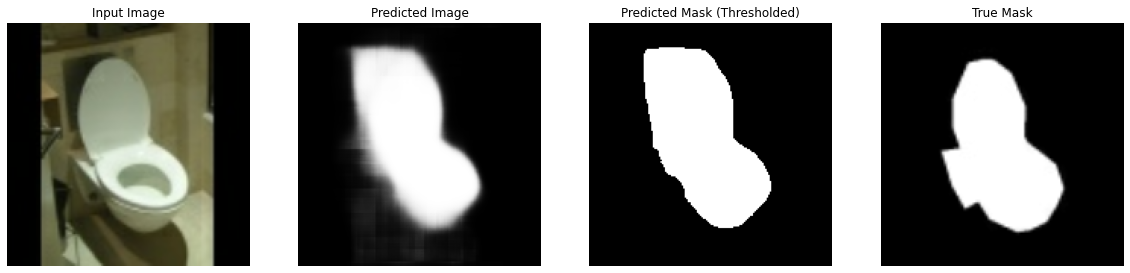

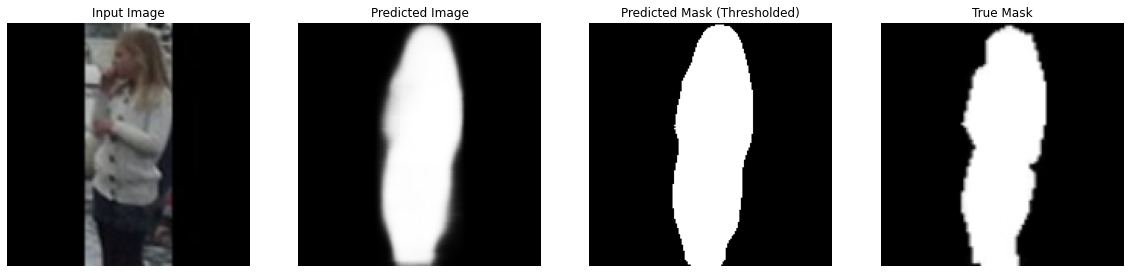

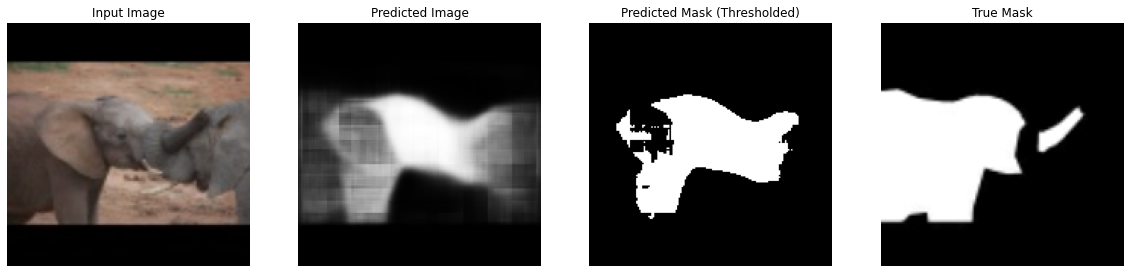

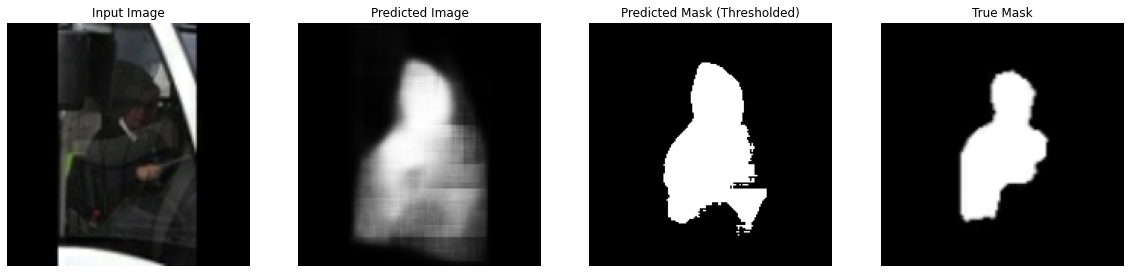

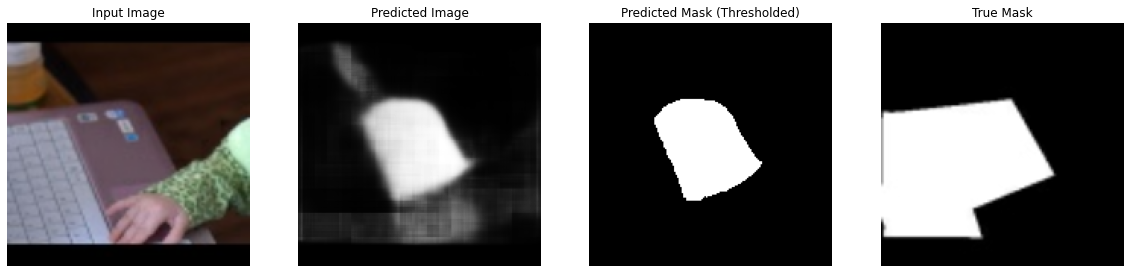

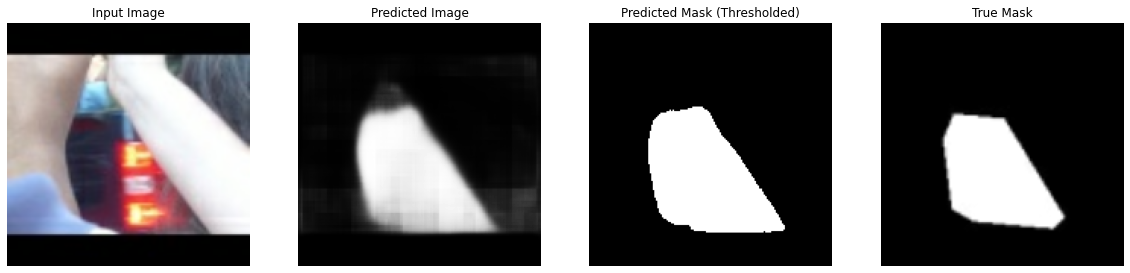

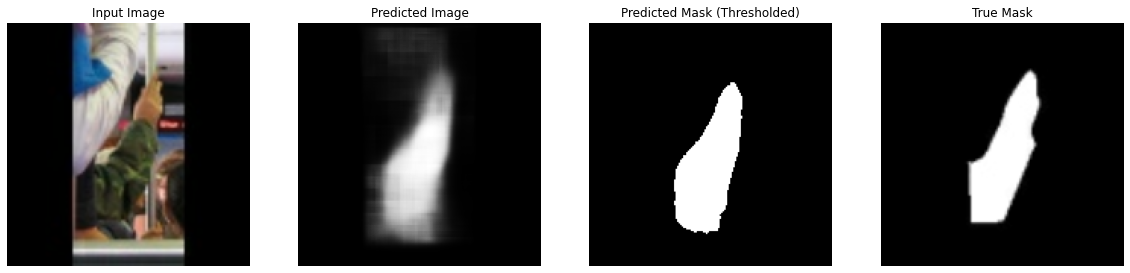

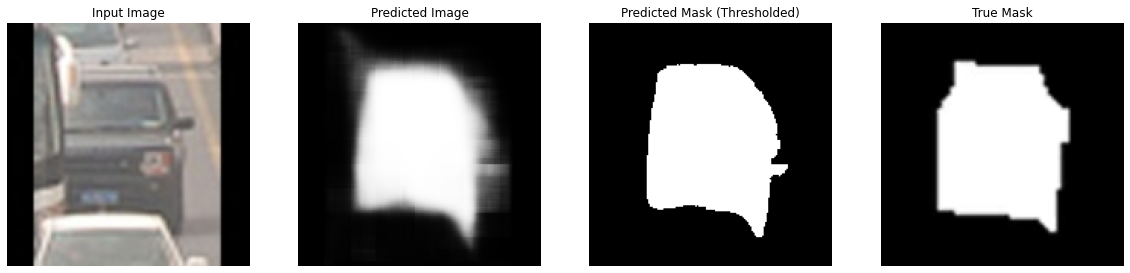

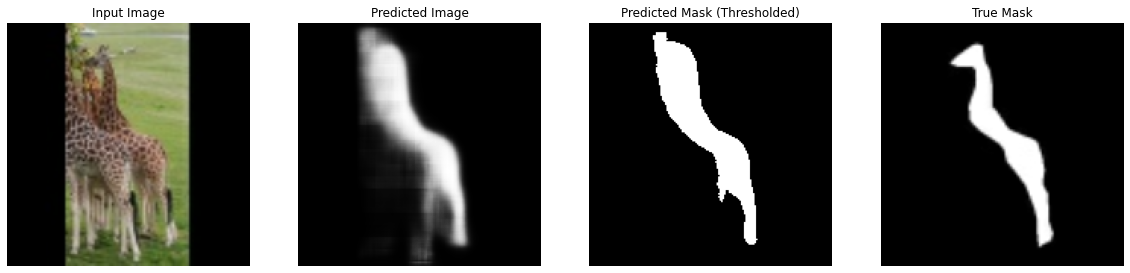

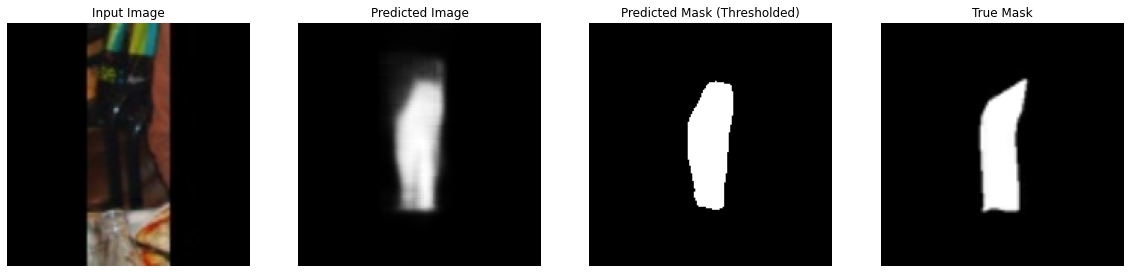

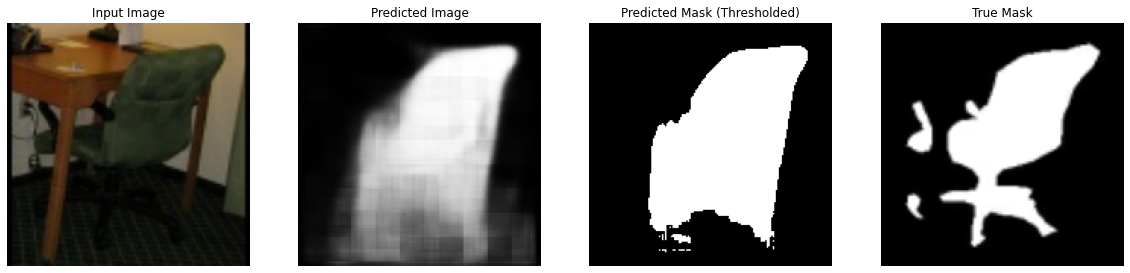

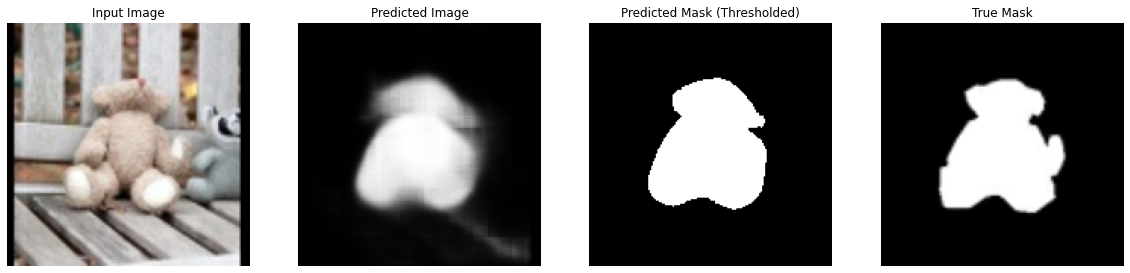

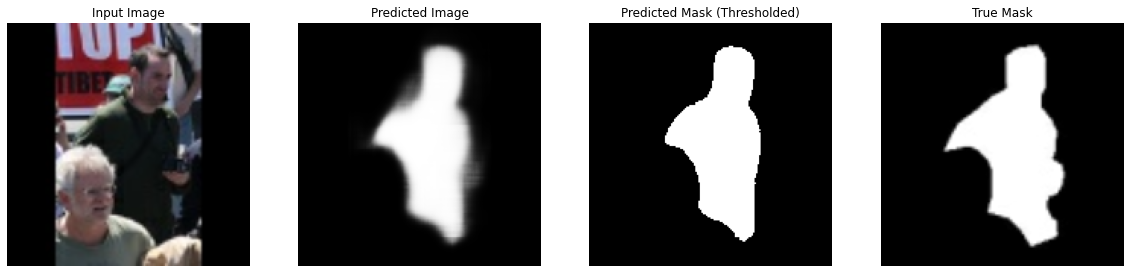

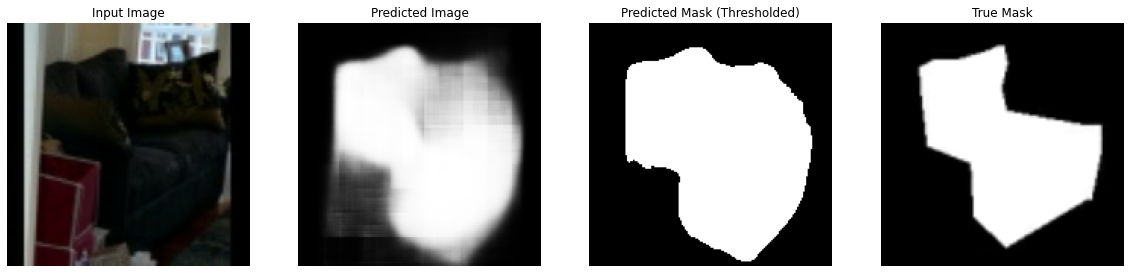

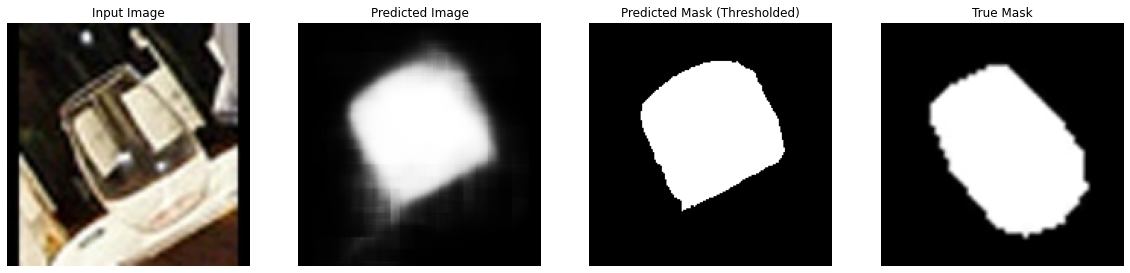

In [7]:
plt.rcParams["figure.figsize"] = (20, 5)

threshold = 0.5

for i, p, t in zip(inputs, preds, targets):
    op = p.copy()
    p[p < threshold] = 0
    p[p >= threshold] = 1
    
    plt.subplot(1, 4, 1)
    plt.imshow(i)
    plt.title("Input Image")
    plt.axis("off")
    plt.subplot(1, 4, 2)
    plt.imshow(op, cmap="gray")
    plt.title("Predicted Image")
    plt.axis("off")
    plt.subplot(1, 4, 3)
    plt.imshow(p, cmap="gray")
    plt.title("Predicted Mask (Thresholded)")
    plt.axis("off")
    plt.subplot(1, 4, 4)
    plt.imshow(t, cmap="gray")
    plt.title("True Mask")
    plt.axis("off")
    plt.show()

In [8]:
def letterbox_image(image, size):
    ih, iw = image.shape[:2]
    w, h = size
    scale = min(w / iw, h / ih)

    # Get the new scaled width and height
    nw = int(scale * iw)
    nh = int(scale * ih)

    # Resize Image based on it's initial size maintaining original aspect ratio
    if nw > iw or nh > ih:
        image = cv2.resize(image, (nw, nh), interpolation=cv2.INTER_CUBIC)
    else:
        image = cv2.resize(image, (nw, nh), interpolation=cv2.INTER_AREA)

    # Create a blank template image
    new_image = np.zeros((h, w, 3), np.uint8)

    # Calculate the offsets
    dx = (w - nw) // 2
    dy = (h - nh) // 2

    new_image[dy : dy + nh, dx : dx + nw] = image

    return new_image

In [20]:
image_paths = glob("/home/ani/Downloads/*")

images = []
dims = 160, 160
for im_path in tqdm(image_paths):
    image = cv2.imread(im_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = letterbox_image(image, dims)
#     image = cv2.resize(image, dims)
    image = image.astype(np.float32)
    image /= 255.
    images.append(image)
    
images = np.array(images)

100%|██████████| 22/22 [00:00<00:00, 35.59it/s]


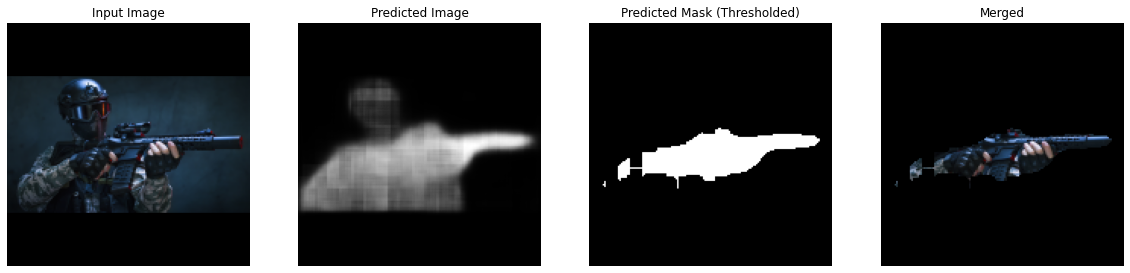

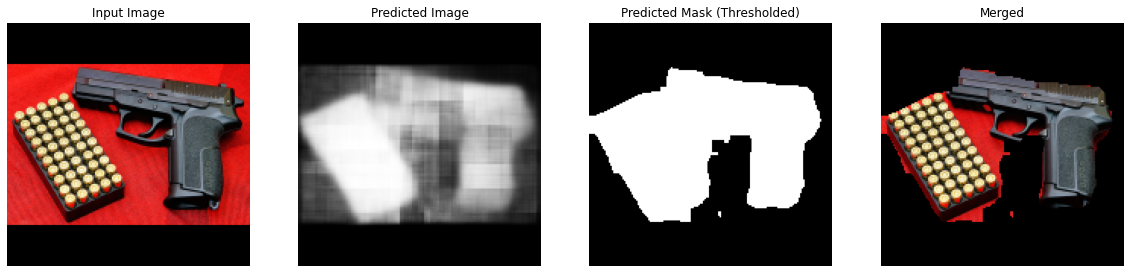

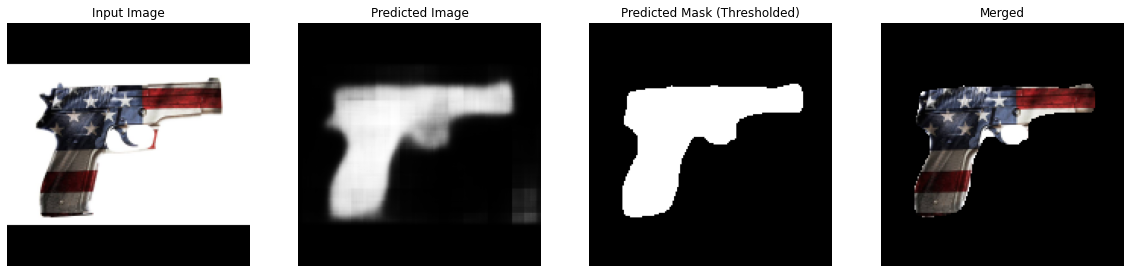

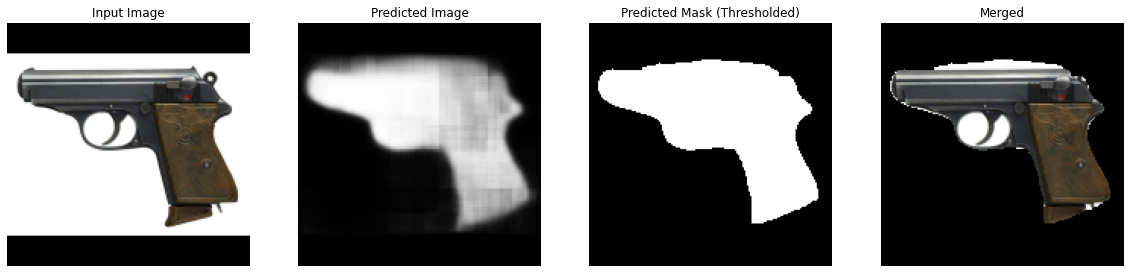

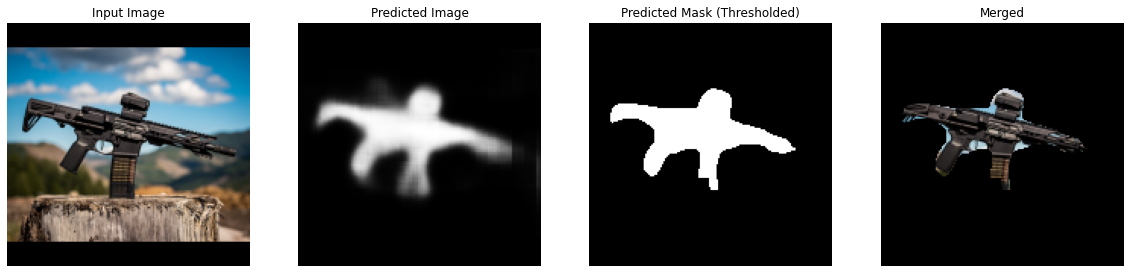

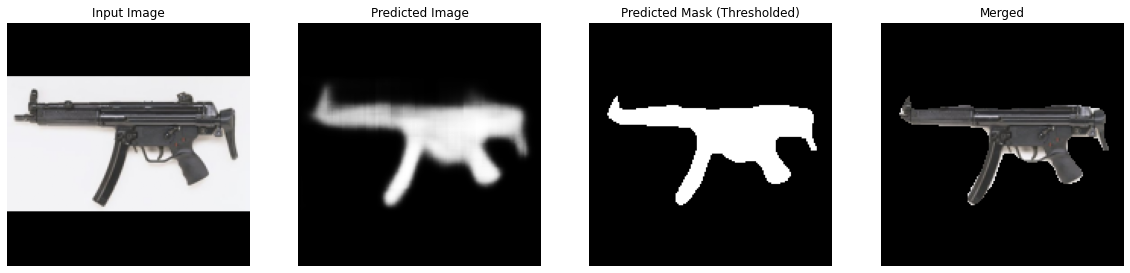

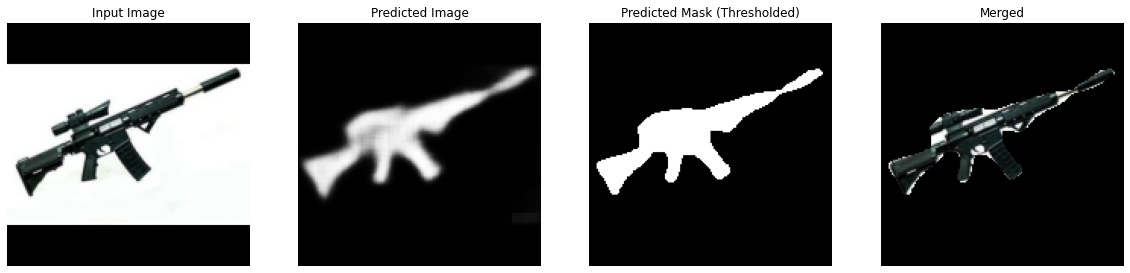

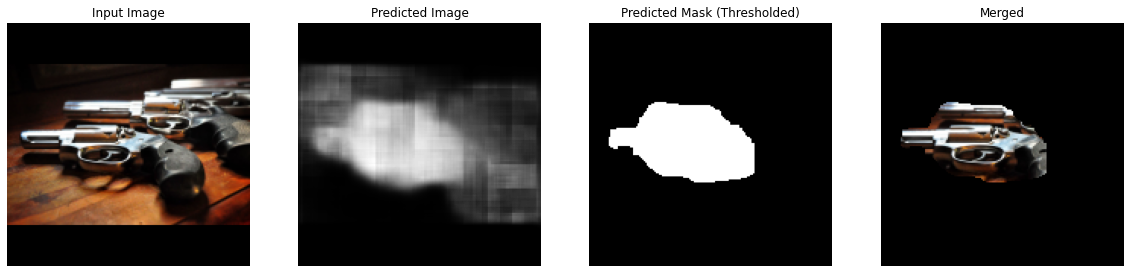

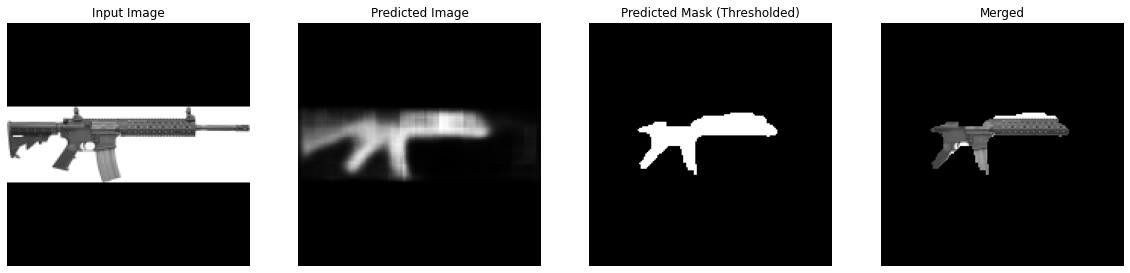

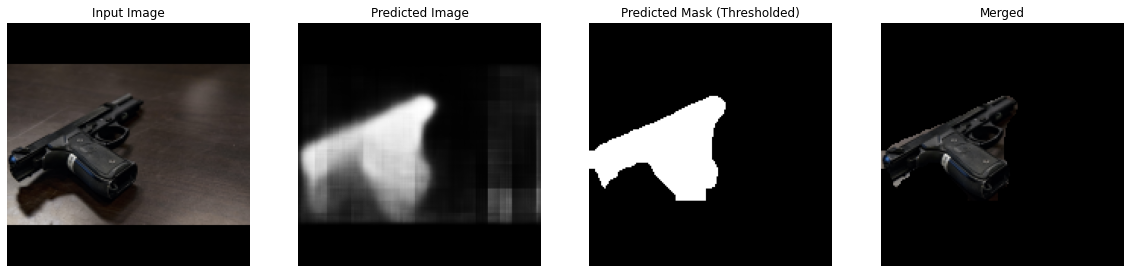

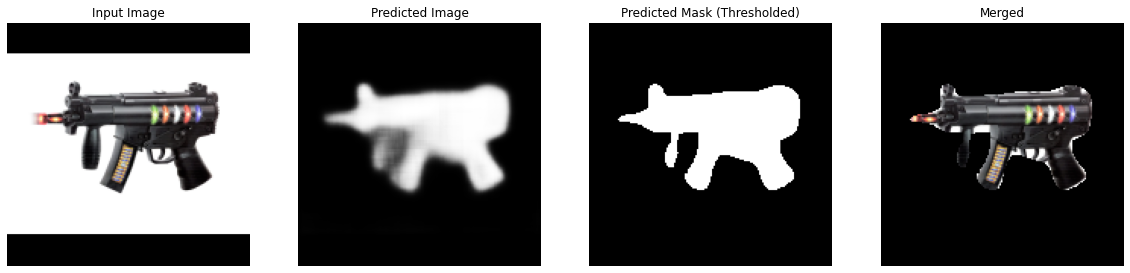

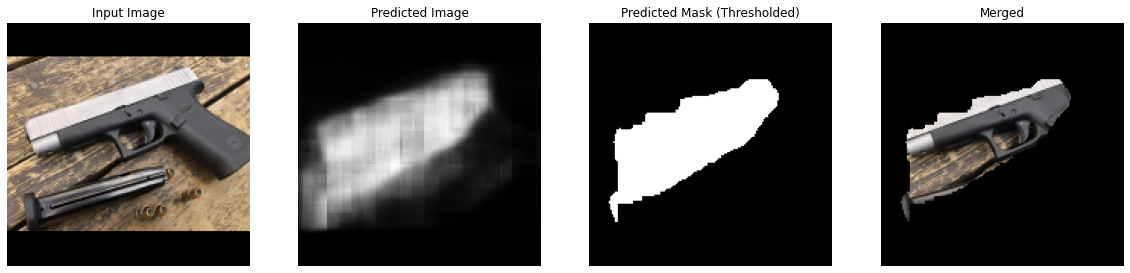

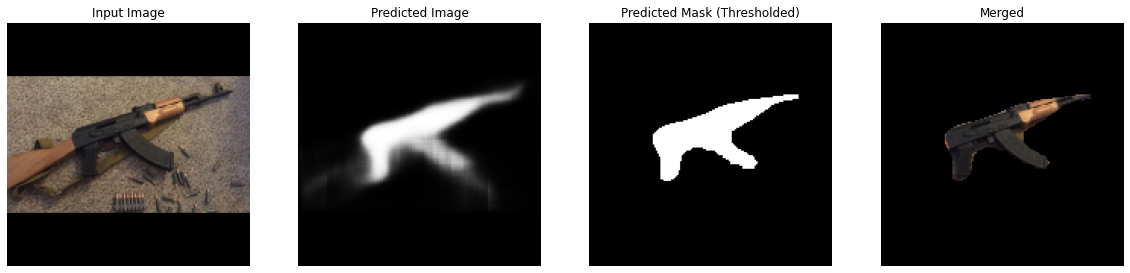

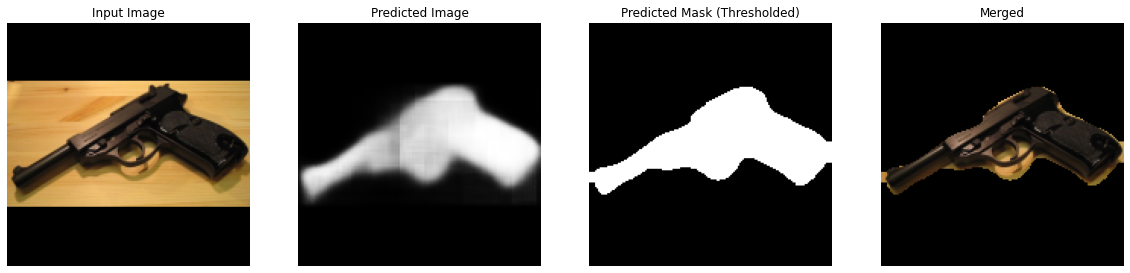

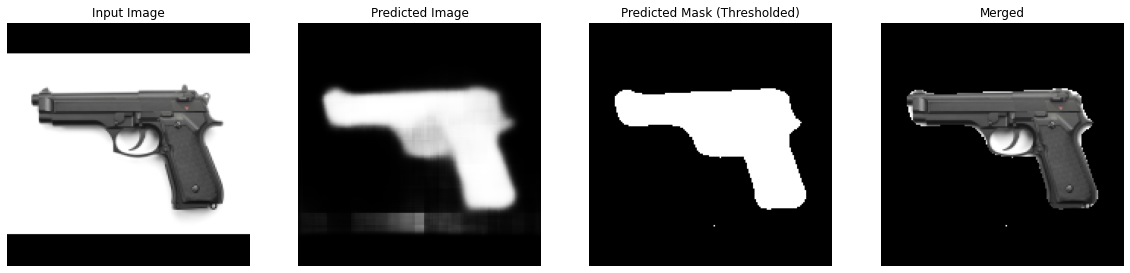

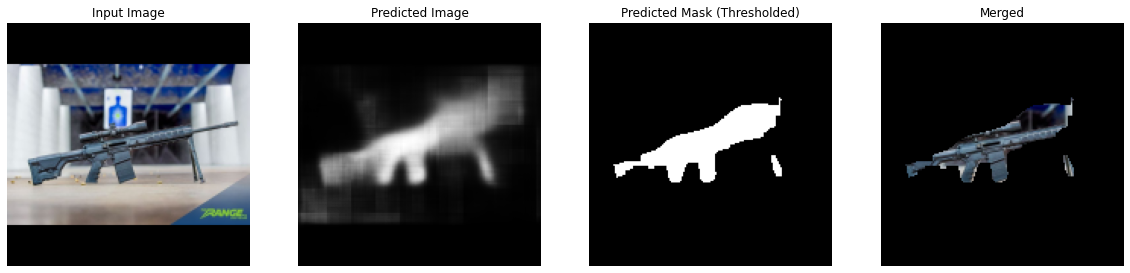

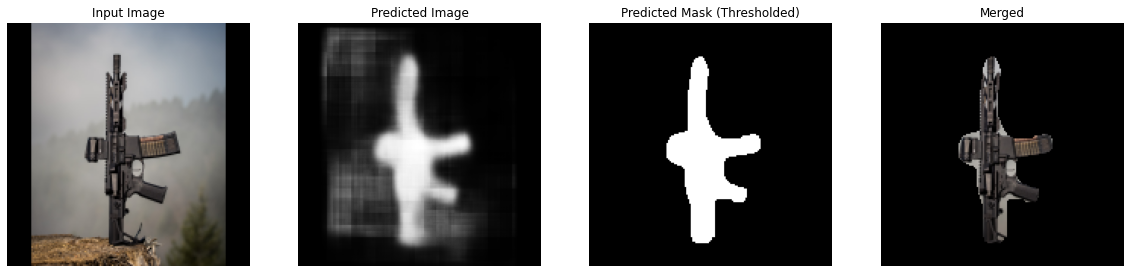

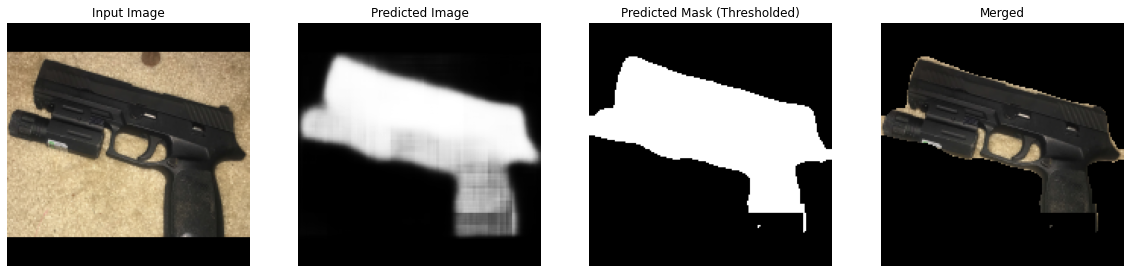

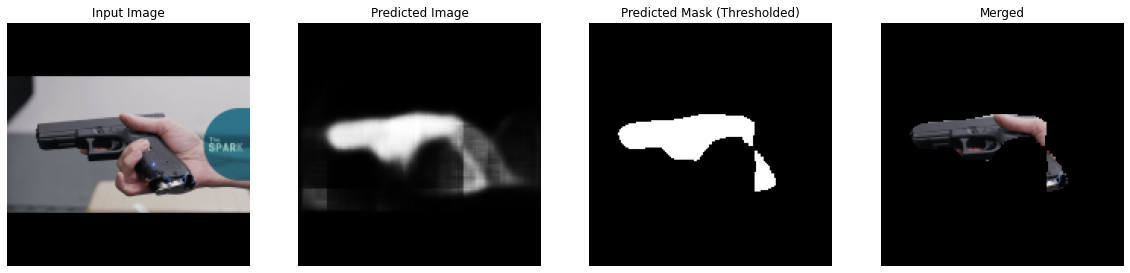

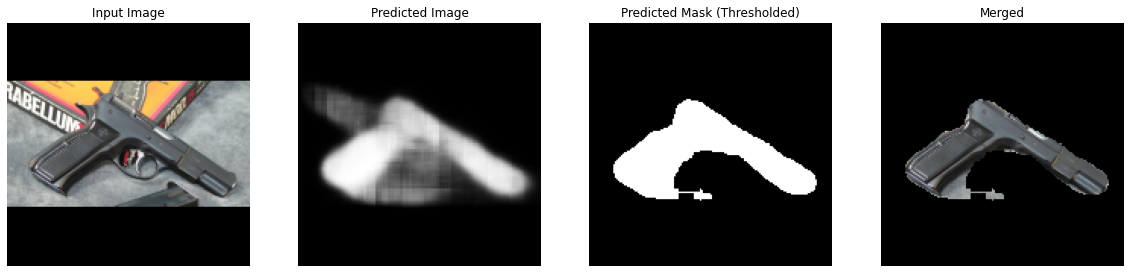

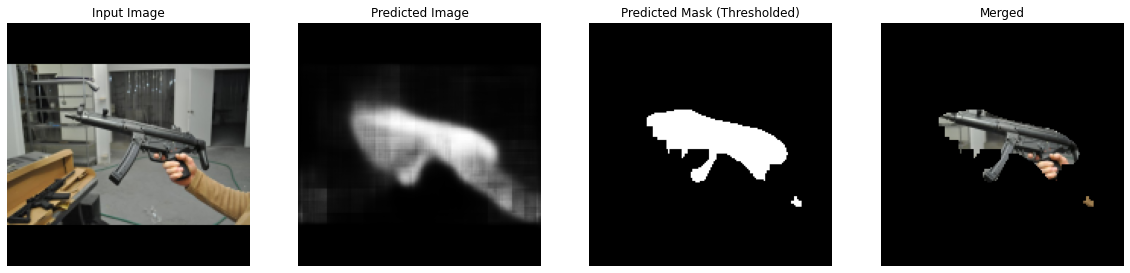

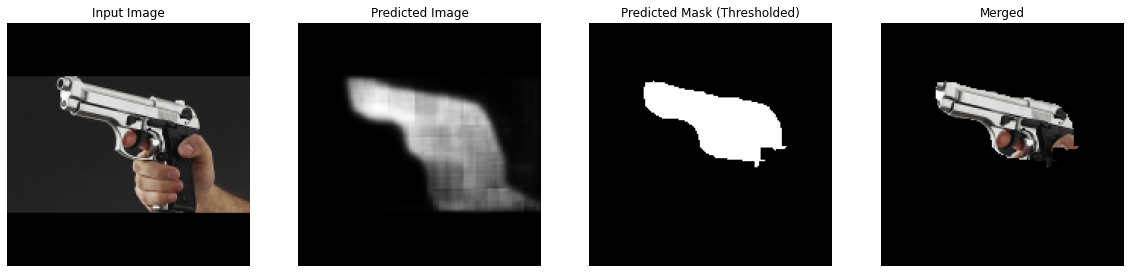

In [21]:
preds = autoencoder.predict(images)

threshold = 0.5

for i, p in zip(images, preds):
    op = p.copy()
    p[p < threshold] = 0
    p[p >= threshold] = 1
    
    p = cv2.morphologyEx(p, cv2.MORPH_CLOSE, np.ones([7, 7]), iterations = 1)
    
    p = np.dstack([p]*3)
    merged = (p * 255).astype(np.uint8) & (i * 255).astype(np.uint8)
    
    plt.subplot(1, 4, 1)
    plt.imshow(i)
    plt.title("Input Image")
    plt.axis("off")
    plt.subplot(1, 4, 2)
    plt.imshow(op, cmap="gray")
    plt.title("Predicted Image")
    plt.axis("off")
    plt.subplot(1, 4, 3)
    plt.imshow(p, cmap="gray")
    plt.title("Predicted Mask (Thresholded)")
    plt.axis("off")
    plt.subplot(1, 4, 4)
    plt.imshow(merged)
    plt.title("Merged")
    plt.axis("off")
    plt.show()